In [1]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import time
import random
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

## Setup dataset

In [2]:
datasets = './data/dataset.jsonl'

with open(datasets, 'r') as file:
    for line_num, line in enumerate(file, 1):
        try:
            json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Error in line {line_num}: {e}")

print("Format JSONL valid.")

Format JSONL valid.


In [3]:
def validate_structure(dataset):
    if not isinstance(dataset, dict):
        return False
    if "messages" not in dataset:
        return False
    if not isinstance(dataset["messages"], list):
        return False
    for message in dataset["messages"]:
        if not isinstance(message, dict):
            return False
        if "role" not in message or "content" not in message:
            return False
    return True


invalid_lines = []

# Validate the structure of each line
with open(datasets, 'r') as file:
    for line_num, line in enumerate(file, 1):
        data = json.loads(line)
        if not validate_structure(data):
            invalid_lines.append(line_num)

if invalid_lines:
    print(f"Invalid structure in lines: {invalid_lines}")
else:
    print("All data structures are valid.")


All data structures are valid.


In [4]:
# Read JSONL file
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data


# check_data_quality function
def check_data_quality(data):
    issues = []
    for index, item in enumerate(data):
        messages = item.get('messages', [])
        if not messages:
            issues.append(f"Item {index}: 'messages' field is missing or empty.")
            continue
        for msg in messages:
            if 'role' not in msg or 'content' not in msg:
                issues.append(f"Item {index}: Missing 'role' or 'content' in message {msg}.")
            if msg['role'] not in ['system', 'user', 'assistant']:
                issues.append(f"Item {index}: Invalid role '{msg['role']}' in message {msg}.")
    return issues


# Load data from JSONL file
data = read_jsonl(datasets)

# Check data quality
issues = check_data_quality(data)

# Display data quality issues
if issues:
    print("Data Quality Issues Found:")
    for issue in issues:
        print(issue)
else:
    print("No data quality issues found.")

# Convert data to DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Display the number of messages in each conversation
df['message_count'] = df['messages'].apply(len)
print(df['message_count'].describe())

# Display the distribution of message counts
message_lengths = []
for item in data:
    for msg in item['messages']:
        message_lengths.append(len(msg['content']))

message_lengths_series = pd.Series(message_lengths)
print(message_lengths_series.describe())


No data quality issues found.
                                            messages
0  [{'role': 'system', 'content': 'Anda adalah AI...
1  [{'role': 'system', 'content': 'Anda adalah AI...
2  [{'role': 'system', 'content': 'Anda adalah AI...
3  [{'role': 'system', 'content': 'Anda adalah AI...
4  [{'role': 'system', 'content': 'Anda adalah AI...
count    250.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0
Name: message_count, dtype: float64
count    750.000000
mean     160.486667
std      101.120936
min       24.000000
25%       71.500000
50%      182.000000
75%      209.000000
max      949.000000
dtype: float64


## Split the dataset into training, validation, and test sets

In [5]:
data_train = './data/data_train.jsonl'
data_validation = './data/data_validation.jsonl'
data_test = './data/data_test.jsonl'


# Load data from JSONL file
def load_jsonl(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]


data = load_jsonl(datasets)

# Shuffle data
random.shuffle(data)

# Define split ratios
train_ratio = 0.8  # 80% training
validation_ratio = 0.1  # 10% validation
test_ratio = 0.1  # 10% testing

# Calculate split indices
train_index = int(len(data) * train_ratio)
validation_index = train_index + int(len(data) * validation_ratio)

# Split data into training, validation, and testing sets
train_data = data[:train_index]
validation_data = data[train_index:validation_index]
test_data = data[validation_index:]


# Save data to JSONL file
def save_jsonl(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for entry in data:
            f.write(json.dumps(entry) + '\n')


# Save training, validation, and testing data
save_jsonl(train_data, data_train)
save_jsonl(validation_data, data_validation)
save_jsonl(test_data, data_test)

print(f"Training data saved to {data_train}")
print(f"Validation data saved to {data_validation}")
print(f"Testing data saved to {data_test}")


Training data saved to ./data/data_train.jsonl
Validation data saved to ./data/data_validation.jsonl
Testing data saved to ./data/data_test.jsonl


## Estimate the cost of fine-tuning

In [6]:
# Define a function to estimate the cost of fine-tuning
def estimate_fine_tuning_cost(file_path, model="gpt-3.5-turbo"):
    # Define the cost parameters
    cost_per_token = 8.00 / 1_000_000  # Cost per token (e.g., $8.00 per 1M tokens for GPT-3.5 Turbo)
    cost_per_fine_tune = 8.00 / 1_000_000  # Assuming the fine-tuning cost is the same (adjust if necessary)

    # Load the data
    with open(file_path, "r") as file:
        data = [json.loads(line) for line in file]

    # Function to count tokens in a message
    def count_tokens(messages):
        return sum(len(message['content'].split()) for message in messages)

    # Calculate the total number of tokens in the dataset
    total_tokens = sum(count_tokens(example["messages"]) for example in data)

    # Estimate the cost
    training_cost = total_tokens * cost_per_fine_tune
    usage_cost = total_tokens * cost_per_token

    total_cost = training_cost + usage_cost

    return total_tokens, training_cost, usage_cost, total_cost


# Estimate the cost
total_tokens, training_cost, usage_cost, total_cost = estimate_fine_tuning_cost(data_train)

# Display the results
print(f"Total Tokens: {total_tokens}")
print(f"Training Cost: ${training_cost:.2f}")
print(f"Usage Cost: ${usage_cost:.2f}")
print(f"Total Estimated Cost: ${total_cost:.2f}")

Total Tokens: 12658
Training Cost: $0.10
Usage Cost: $0.10
Total Estimated Cost: $0.20


## Upload data to OpenAI

In [7]:
load_dotenv(dotenv_path='./apiKey.env')

openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

In [10]:
# Upload the training data
training_response = client.files.create(
    purpose='fine-tune',
    file=open(datasets, 'rb'),
)

training_file_id = training_response.id
print("Training file id:", training_file_id)

Training file id: file-TWtPL8FYngBV0FZ8pUJHUgc0


In [11]:
# Upload the validation data
validation_response = client.files.create(
    purpose='fine-tune',
    file=open(data_validation, 'rb'),
)

validation_file_id = validation_response.id
print("Validation file id:", validation_file_id)

Validation file id: file-0JjHJt45fZImclCWrhACUj2g


In [11]:
# Upload the test data
# test_response = client.files.create(
#     purpose='fine-tune',
#     file=open(data_test, 'rb'),
# )
# 
# test_file_id = test_response.id
# print("Test file id:", test_file_id)

## Fine-tune model with new data

In [12]:
fine_tune_response = client.fine_tuning.jobs.create(
    model="ft:gpt-3.5-turbo-0125:personal:bpa-itpln-1:9rQIP8GK",
    training_file=training_file_id,
    validation_file=validation_file_id,
    suffix="bpa_itpln_8",
    hyperparameters={
        # set epochs number
        "n_epochs": 4,
        # set batch size
        "batch_size": 4,
        # set learning rate
        "learning_rate_multiplier": 2,
        # set max tokens
        "max_tokens": 2048,
        # set validation every
        "validation_every_n_epochs": 1,
        # set early stopping
        "early_stopping": True,
        # set early stopping patience
        "early_stopping_patience": 1,
        # set early stopping metric
        "early_stopping_metric": "loss",
        # set early stopping metric mode
        "early_stopping_metric_mode": "min",
        # set early stopping metric delta
        "early_stopping_metric_delta": 0.01,
        # set validation metric
        "validation_metric": "loss",
        # set validation metric mode
        "validation_metric_mode": "min",
    }
)

fine_tune_id = fine_tune_response.id

print(f"Fine-tuning started with ID: {fine_tune_id}")
print(fine_tune_response)

Fine-tuning started with ID: ftjob-Y6xOasnc2NBdGOUVAOfR3fqI
FineTuningJob(id='ftjob-Y6xOasnc2NBdGOUVAOfR3fqI', created_at=1722592556, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=2, batch_size=1, learning_rate_multiplier=2.0), model='ft:gpt-3.5-turbo-0125:personal:bpa-itpln-1:9rQIP8GK', object='fine_tuning.job', organization_id='org-lv4C6T43m3ZXCtmBwhwKWPU5', result_files=[], seed=543143490, status='validating_files', trained_tokens=None, training_file='file-TWtPL8FYngBV0FZ8pUJHUgc0', validation_file='file-0JjHJt45fZImclCWrhACUj2g', estimated_finish=None, integrations=[], user_provided_suffix='bpa_itpln_7')


## Monitor the fine-tuning process

In [13]:
while True:
    status_response = client.fine_tuning.jobs.retrieve(fine_tune_id)
    print(status_response)
    if status_response.status == 'succeeded':
        break
    time.sleep(60)  # Check every minute

# Get the fine-tuned model ID
result_response = client.fine_tuning.jobs.retrieve(fine_tune_id)
print(result_response)

FineTuningJob(id='ftjob-Y6xOasnc2NBdGOUVAOfR3fqI', created_at=1722592556, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=2, batch_size=1, learning_rate_multiplier=2.0), model='ft:gpt-3.5-turbo-0125:personal:bpa-itpln-1:9rQIP8GK', object='fine_tuning.job', organization_id='org-lv4C6T43m3ZXCtmBwhwKWPU5', result_files=[], seed=543143490, status='validating_files', trained_tokens=None, training_file='file-TWtPL8FYngBV0FZ8pUJHUgc0', validation_file='file-0JjHJt45fZImclCWrhACUj2g', estimated_finish=None, integrations=[], user_provided_suffix='bpa_itpln_7')
FineTuningJob(id='ftjob-Y6xOasnc2NBdGOUVAOfR3fqI', created_at=1722592556, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=2, batch_size=1, learning_rate_multiplier=2.0), model='ft:gpt-3.5-turbo-0125:personal:bpa-itpln-1:9rQIP8GK', object='fine_tuning.job', organization_id='

In [14]:
# Check status of fine-tuning job
status = client.fine_tuning.jobs.retrieve(fine_tune_id)
if status.status == "succeeded":
    print("Model is ready for use!")
    model_id = status.id
    model_runtime = status.finished_at - status.created_at
    model_trained_tokens = status.trained_tokens
    model_hyperparams = status.hyperparameters
    model_name = status.fine_tuned_model
    model_result_files = status.result_files
    print(f"Model name: {model_name}")
    print(f"Model runtime: {model_runtime} seconds")
    print(f"Model trained tokens: {model_trained_tokens}")
    print(f"Model hyperparameters: {model_hyperparams}")
    print(f"Model result files: {model_result_files}")
elif status.status == "running":
    print("Model is not ready yet, try again later")
else:
    print('status:', status.status)

Model is ready for use!
Model name: ft:gpt-3.5-turbo-0125:personal:bpa-itpln-7:9rjaGHZQ
Model runtime: 1079 seconds
Model trained tokens: 73278
Model hyperparameters: Hyperparameters(n_epochs=2, batch_size=1, learning_rate_multiplier=2.0)
Model result files: ['file-qO79qfvwprY89C7BnhEtyOGg']


## Evaluate the model accuracy

In [15]:
# Load test data
with open(data_validation, 'r') as f:
    test_data = [json.loads(line) for line in f]

true_responses = []
predicted_responses = []

# Evaluate model on test data
for item in test_data:
    messages = item['messages']

    response = client.chat.completions.create(
        model=status.fine_tuned_model,
        messages=messages[:-1]  # Exclude the assistant's response
    )

    predicted_completion = response.choices[0].message.content.strip()
    expected_completion = messages[-1]['content'].strip()

    true_responses.append(expected_completion)
    predicted_responses.append(predicted_completion)

# Calculate accuracy
accuracy = accuracy_score(true_responses, predicted_responses)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_responses, predicted_responses, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')


Accuracy: 44.00%
Precision: 44.00%
Recall: 44.00%
F1-Score: 44.00%


C:\Users\ramadhani.pratama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ramadhani.pratama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\ramadhani.pratama\AppData\Local\Temp\ipykernel_27976\3388856654.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Metric', data=metrics_df, palette='viridis')


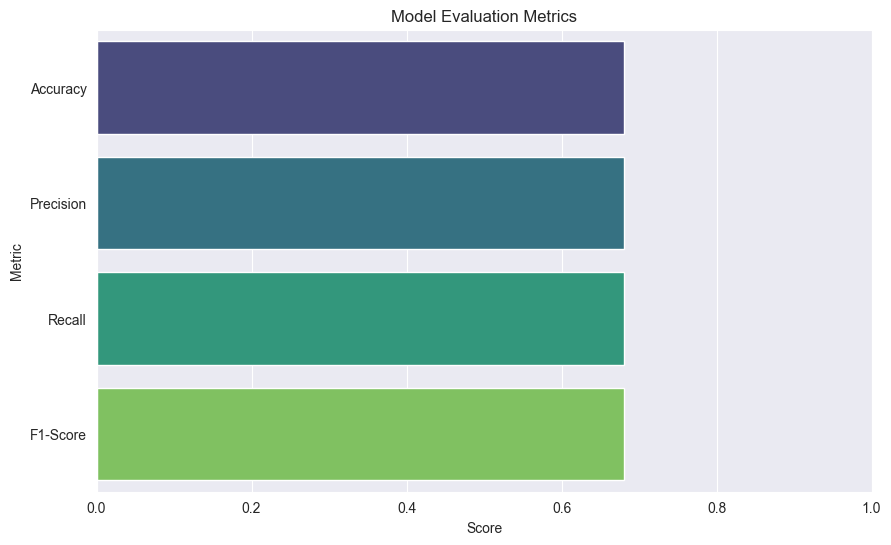

In [23]:
# Create a DataFrame for the metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Metric', data=metrics_df, palette='viridis')
plt.title('Model Evaluation Metrics')
plt.xlabel('Score')
plt.ylabel('Metric')
plt.xlim(0, 1)
plt.show()